<a href="https://colab.research.google.com/github/lzgustavo13/Projeto-Sinais/blob/main/Genre-classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MUSIC GENRE CLASSIFICATOR**

Projeto desenvolvido para a disciplina de Sinais e Sistemas, tem como objetivo classificar o gênero de músicas utilizando a extração de características a partir de dados de áudio. A abordagem envolve a aplicação da Transformada de Fourier para analisar os sinais de áudio e extrair informações espectrais, que são então utilizadas para treinar um modelo de classificação. O projeto abrange desde o pré-processamento dos dados até a construção do classificador, visando identificar corretamente o gênero das músicas com base nas características extraídas.


Equipe: Heitor Cordeiro e Luiz Gustavo

## 1.   **Importação de bibliotecas**



In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive
from google.colab import output
import librosa.display
import soundfile as sf
from IPython.display import Audio
import IPython.display as display

drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/archive/Data/genres_original/"
genres = os.listdir(data_dir)
dataset = []
labels = []
total_files = 0
total_chunks = 0

Mounted at /content/drive


## 2. **Pré-Processamento**

A estratégia utilizada foi dividir o áudio de 30 segundos, em áudios menores (chunks) de 6 segundos de duração, de modo com que, um único áudio fosse dividido em 5 chunks.

In [ ]:
def processar_chunk(y, sr, chunk_duration=6, overlap_duration=1):
    """
    Função que divide o áudio em chunks e retorna uma lista de chunks extraídos.

    Parâmetros:
    y (ndarray): Sinal de áudio carregado.
    sr (int): Taxa de amostragem.
    chunk_duration (int): Duração de cada chunk em segundos.
    overlap_duration (int): Duração da sobreposição entre os chunks em segundos.

    Retorna:
    list: Lista de chunks extraídos do áudio.
    """
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr

    # Calcular o número de chunks
    num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

    chunks = []

    # Iterar sobre cada chunk
    for i in range(num_chunks):
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples

        # Extrair o chunk de áudio
        chunk = y[start:end]
        if len(chunk) < chunk_samples:
            break

        chunks.append(chunk)

    return chunks


## 3. **Extração de Features**
As features selecionadas estão presentes nas especificações do projeto e foram escolhidas de acordo com a eficácia, complexidade e recomendações de artigos acadêmicos.

In [ ]:
def extract_features(y, sr):
    features = []

    # FFT - Espectro de frequência
    fft = np.fft.fft(y)
    features.append(float(np.mean(np.abs(fft))))
    features.append(float(np.var(np.abs(fft))))

    # Tempo (BPM)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features.append(float(tempo[0]))

    # Espectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(float(np.mean(spectral_centroid)))
    features.append(float(np.var(spectral_centroid)))

    # Spectral Rolloff
    spec_roll = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features.append(float(np.mean(spec_roll)))
    features.append(float(np.var(spec_roll)))

    # Spectral Bandwidth
    spec_band = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features.append(float(np.mean(spec_band)))
    features.append(float(np.var(spec_band)))

    # Root Mean Square Energy (RMSE)
    RMSEn = librosa.feature.rms(y=y)
    features.append(float(np.mean(RMSEn)))
    features.append(float(np.var(RMSEn)))

    # Zero-Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    features.append(float(np.mean(zero_crossing_rate)))
    features.append(float(np.var(zero_crossing_rate)))

    # Chromagram
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    features.append(float(np.mean(chromagram)))
    features.append(float(np.var(chromagram)))

    # MFCCs (13 coeficientes)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for mfcc in mfccs:
        features.append(float(np.mean(mfcc)))
        features.append(float(np.var(mfcc)))

    return features

## 4. **Processamento dos dados**
Aqui basicamente estamos carregando todos os áudios do GTZAN, criando os chunks e por fim fazendo a extração das features.

In [ ]:
for genre in genres:
    genre_path = os.path.join(data_dir, genre)
    if not os.path.isdir(genre_path):
        continue
    files = os.listdir(genre_path)
    for file in files:
        file_path = os.path.join(genre_path, file)
        try:
            y, sr = librosa.load(file_path, sr=22050)  # Carregar áudio
            total_files += 1

            # Chamar a função para processar os chunks
            chunks = processar_chunk(y, sr, chunk_duration=6, overlap_duration=1)

            # Para cada chunk, extrair features e adicionar ao dataset
            for chunk in chunks:
                features = extract_features(chunk, sr)
                dataset.append(features)
                labels.append(genre)

        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}. Pulando...")


print(f"Total de arquivos processados: {total_files}")

<ipython-input-5-662a81b08bf5>:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)  # Carregar áudio
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erro ao processar /content/drive/MyDrive/archive/Data/genres_original/jazz/jazz.00054.wav: . Pulando...
Total de arquivos processados: 999


## 5. **Ajuste de parâmetros**
Visando a realização dos testes, modelo selecionado Random Forest.

In [ ]:
df = pd.DataFrame(dataset)
df['label'] = labels
X = df.drop(columns=['label'])
y = df['label']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste de Hiperparâmetros para Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

## 6. **Treinamento**

In [ ]:
clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)

print("Melhor parâmetro encontrado: ", clf.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhor parâmetro encontrado:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## 7. **Resultados**

Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8298298298298298
              precision    recall  f1-score   support

       blues       0.86      0.85      0.85       104
   classical       0.91      0.94      0.92        82
     country       0.72      0.77      0.75        93
       disco       0.79      0.85      0.82        95
      hiphop       0.90      0.85      0.87       104
        jazz       0.79      0.89      0.83        97
       metal       0.88      0.91      0.90       109
         pop       0.92      0.81      0.86       110
      reggae       0.77      0.84      0.80        93
        rock       0.77      0.63      0.70       112

    accuracy                           0.83       999
   macro avg       0.83      0.83      0.83       999
weighted avg       0.83      0.83      0.83       999



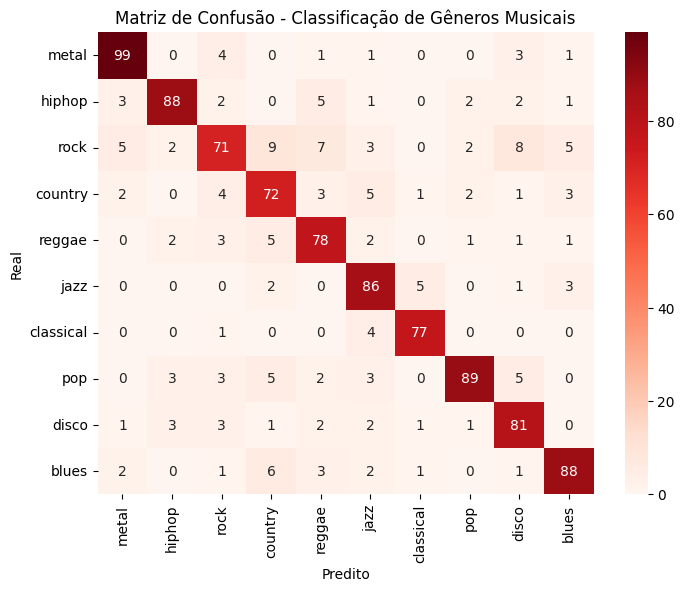

In [ ]:
print(f"Melhores parâmetros: {clf.best_params_}")
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=genres)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=genres, yticklabels=genres)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Classificação de Gêneros Musicais")
plt.show()

## 8. **Áudio com eco**

In [ ]:

file_path = "/content/drive/MyDrive/archive/Data/genres_original/hiphop/hiphop.00000.wav"

# Carregar o áudio
y, sr = librosa.load(file_path, sr=None)

# Parâmetros do eco
delay_sec = 0.5  # Tempo do eco em segundos
decay = 0.6  # Fator de redução do volume do eco
delay_samples = int(sr * delay_sec)  # Converter segundos para amostras


impulse_response = np.zeros(delay_samples * 2)
impulse_response[0] = 1  # Áudio original
impulse_response[delay_samples] = decay  # Eco

# Aplicar convolução para gerar o efeito de eco
y_with_echo = np.convolve(y, impulse_response, mode="full")

# Extrair todas as features do áudio com eco
features = extract_features(y_with_echo, sr)

predicao = clf.predict([features])
print(f'Predição com Eco: {predicao}')

Predição com Eco: ['hiphop']


## 9. **Tocando áudio com Eco**

In [ ]:
# Salvar o novo áudio
Audio(data=y_with_echo, rate=sr)

## 10. **Áudio com Ruído**

In [ ]:
file_path = "/content/drive/MyDrive/archive/Data/genres_original/hiphop/hiphop.00000.wav"

# Carregar o áudio
y, sr = librosa.load(file_path, sr=None)

# Parâmetros do ruído
noise_factor = 0.02  # Fator de intensidade do ruído

# Gerar ruído branco com mesma forma do sinal original
noise = noise_factor * np.random.randn(len(y))

# Adicionar ruído ao sinal original
y_noise = y + noise

# Normalizar para manter os valores no intervalo [-1, 1]
y_noise = np.clip(y_noise, -1, 1)

# Extrair todas as features do áudio com ruído
features = extract_features(y_noise, sr)

predicao = clf.predict([features])

print(f'Predição: {predicao}')

Predição: ['hiphop']


## 11. **Tocando Áudio com Ruído**

In [ ]:
# Tocar o áudio modificado com ruído
Audio(data=y_noise, rate=sr)

## 12. **Áudio Original**

In [ ]:
# Tocar o áudio modificado com ruído
Audio(data=y, rate=sr)

## 13. **Carregando Áudio**

In [ ]:
from google.colab import output
from base64 import b64decode
import librosa
import numpy as np
import IPython.display as display
from IPython.display import Audio
import soundfile as sf

# Criar um widget de gravação no Colab (HTML + JS) mostrando tempo restante
RECORD_SCRIPT = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time));
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = () => resolve(reader.result.split(',')[1]);
  reader.readAsDataURL(blob);
});

async function record(sec) {
  let statusDiv = document.createElement("div");
  statusDiv.style.fontSize = "20px";
  statusDiv.style.fontWeight = "bold";
  statusDiv.innerText = " Gravando... Tempo restante: " + sec + "s";
  document.body.appendChild(statusDiv);

  stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  recorder = new MediaRecorder(stream);
  chunks = [];
  recorder.ondataavailable = e => chunks.push(e.data);
  recorder.start();

  for (let i = sec; i > 0; i--) {
    statusDiv.innerText = " Gravando... Tempo restante: " + i + "s";
    await sleep(1000);
  }

  recorder.stop();
  statusDiv.innerText = " Processando gravação...";
  await sleep(1000);

  let audioData = await b2text(new Blob(chunks));
  statusDiv.innerText = " Gravação concluída!";

  google.colab.kernel.invokeFunction('notebook.rec_audio', [audioData], {});
}

record(30);
"""

# Função para salvar o áudio gravado no formato WAV
def save_audio(js_data):
    audio_bytes = b64decode(js_data)
    file_path = "/content/audio_gravado.wav"

    with open(file_path, "wb") as f:
        f.write(audio_bytes)

    print(f" Áudio salvo em: {file_path}")

    #  Reproduzir o áudio original
    print(" Reproduzindo áudio original...")
    display.display(Audio(file_path, rate=22050))

# Registra a função no Colab para capturar o áudio gravado
output.register_callback('notebook.rec_audio', save_audio)

# Executa o JavaScript para iniciar a gravação
print(" Iniciando gravação por 5 segundos...")
output.eval_js(RECORD_SCRIPT)

 Iniciando gravação por 5 segundos...
 Áudio salvo em: /content/audio_gravado.wav
 Reproduzindo áudio original...


## 14. **Realizando predição com áudio gravado**

In [ ]:
import numpy as np
import librosa

file_path = "/content/audio_gravado.wav"


y, sr = librosa.load(file_path, sr=None)

chunk_size = int(6 * sr)  # Exemplo: chunks de 1 segundo
features_list = []

for i in range(0, len(y), chunk_size):
    chunk = y[i : i + chunk_size]
    if len(chunk) < chunk_size:
        break  # Evita que um chunk muito pequeno seja processado
    features = extract_features(chunk, sr)
    features_list.append(features)

features_array = np.array(features_list)

# Fazer predição para cada chunk
predicoes = clf.predict(features_array)

print(f'Predições: {predicoes}')


<ipython-input-43-9ee221121909>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Predições: ['reggae' 'reggae' 'reggae' 'pop' 'reggae']
